In [1]:
import matplotlib
import matplotlib.pyplot as plt
import hidden_motif as hm
import random
from tqdm import tqdm
from numpy import argmin
from Bio import SeqIO
import pickle
import os
import pandas as pd

In [2]:
backend = matplotlib.get_backend()
interactive = matplotlib.is_interactive()
print('Using backend', backend, ', interactive = ', interactive)

Using backend module://ipykernel.pylab.backend_inline , interactive =  True


In [10]:
def print_one_per_line(list_like):
    for i, line in enumerate(list_like):
        print('{:>3} {}'.format(i, line))

In [13]:
def read_fasta(file_name):
    parsed = SeqIO.parse(file_name, 'fasta')
    segment_IDs = []
    segments = []
    for record in parsed:
        segment_IDs.append(record.id)
        segments.append(str(record.seq))
    return segment_IDs, segments

Let's generate some synthetic data, with 36 DNA segments, each of length 250, inserting in each a motif of size 6. Each of the four possible nucleotides is generated with the same probability for the segments and the motif. We set the seed for the random number generator to make the experiment repeatable.
The modest motif size allows to find it via median string in reasonable time.

In [4]:
file_name = 'synthetic01'

In [5]:
motif = hm.generate_dataset(file_name=file_name+'.fasta',
                         n_segments=36,
                         segment_length=250,
                         motif_length=6,
                         proportions=None,
                         seed=6)
print('Inserted motif:', motif)

Inserted motif: TTCCAG


In [19]:
parsed = SeqIO.parse(file_name+'.fasta', 'fasta')
segment_IDs = []
segments = []
for record in parsed:
    segment_IDs.append(record.id)
    segments.append(str(record.seq))

In [7]:
median4, dist4 = hm.median_string(segments, 4, progress_bar=True)

100%|██████████| 256/256 [00:02<00:00, 104.68it/s]


In [9]:
median4, dist4

('CCAG', 0)

In [10]:
median6, dist6 = hm.median_string(segments, 6, progress_bar=True)

100%|██████████| 4096/4096 [00:44<00:00, 93.31it/s]


In [11]:
median6, dist6

('TTCCAG', 0)

In [12]:
median7, dist7 = hm.median_string(segments, 7, progress_bar=True)

100%|██████████| 16384/16384 [03:04<00:00, 89.24it/s]


In [13]:
median7, dist7

('ATTCCAG', 23)

Computation times grows exponentially with the length of the k-mer we are looking for. Gibbs sampling allows us to look for longer k-mers. The next generated synthetic data has a motif of 16 nucloetides inserted in a random position into each DNA segment.

In [8]:
file_name = 'synthetic02'

In [9]:
motif = hm.generate_dataset(file_name=file_name+'.fasta',
                         n_segments=36,
                         segment_length=250,
                         motif_length=16,
                         proportions=None,
                         seed=1)
print('Inserted motif:', motif)

Inserted motif: ATTCCCGTAATCTACG


In [15]:
# random.seed(1)

# parsed = SeqIO.parse('upstream250.txt', 'fasta')
segment_IDs, segments = read_fasta(file_name+'.fasta')

best_scores = []
best_scores_iter = []
best_motifs = []
consensus = []
ks = range(8, 24, 1)
for k in tqdm(ks):
    motifs, scores = hm.gibbs_sampler(segments, k=k, n=10000, seed=None)
    best_scores.append(min(scores))
    best_scores_iter.append(argmin(scores))
    best_motifs.append(motifs)
    consensus.append(hm.consensus_from_motifs(motifs))

100%|██████████| 16/16 [02:02<00:00,  9.10s/it]


In [16]:
with open(file_name+'.pickle', 'wb') as pickle_file:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump((ks, best_scores, best_scores_iter, best_motifs, consensus), pickle_file, pickle.HIGHEST_PROTOCOL)

In [17]:
if os.path.isfile(file_name+'.pickle'):
    with open(file_name+'.pickle', 'rb') as pickle_file:
        ks, best_scores, best_scores_iter, best_motifs, consensus = pickle.load(pickle_file)

In [18]:
print_one_per_line(consensus)

  0 TATTCCCG
  1 ATTCCCGTA
  2 CTATTCCCGT
  3 GTAATCTACGG
  4 CGTAATCTACGG
  5 TATTCCCGTAATC
  6 GTAATCTACGGGGT
  7 TCCCGTAATCTACGG
  8 CTATTCCCGTAATCTA
  9 CCCGTAATCTACGGGGT
 10 ATTCCCGTAATCTACGGG
 11 ATTCCCGTAATCTACGGGG
 12 CACAATTCCCGTAATCTACG
 13 ACAATTCCCGTAATCTACGGG
 14 GCGGGAGCACTATTCCCGTAAT
 15 TATTCCCGTAATCTACGGGGTGA


In [ ]:
for item in best_motifs:
    print()
    print_one_per_line(sorted(item))

In [19]:
import numpy as np
best_scores = np.array(best_scores)
best_scores_norm = [best_scores[i]/k for i, k in enumerate(ks)]

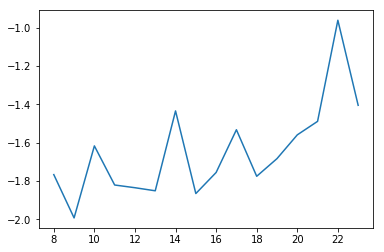

In [20]:
plt.plot(ks, best_scores_norm)

In [28]:
[hm.kmer_to_dna_distance(item, segments) for item in consensus]

[23, 0, 45, 23, 23, 23, 98, 23, 46, 98, 49, 74, 100, 123, 269, 170]

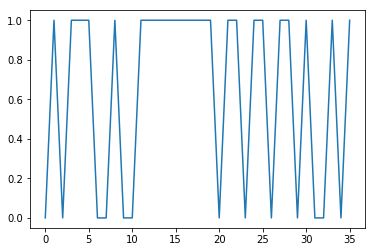

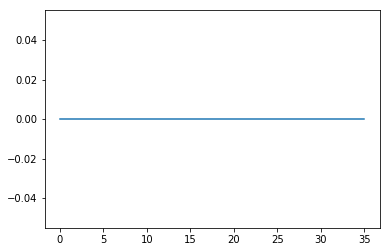

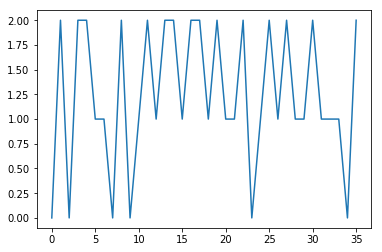

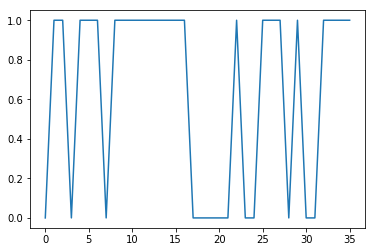

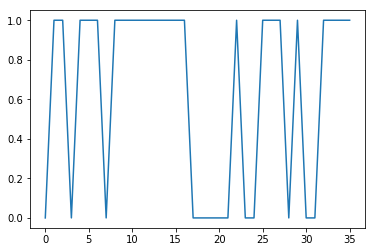

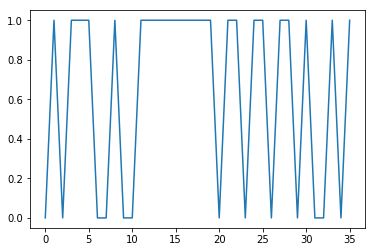

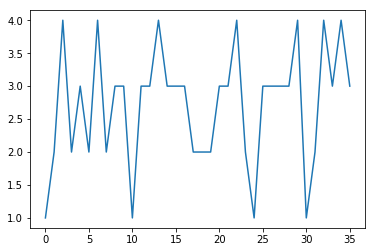

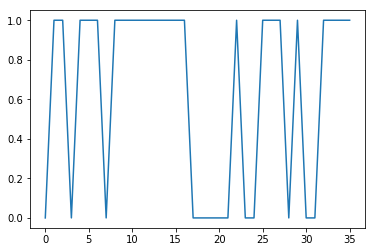

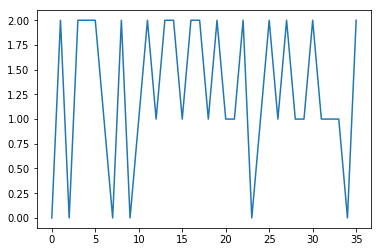

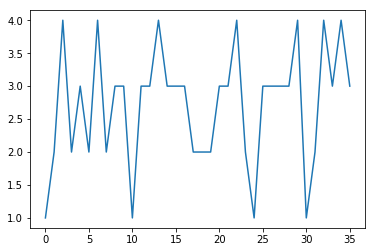

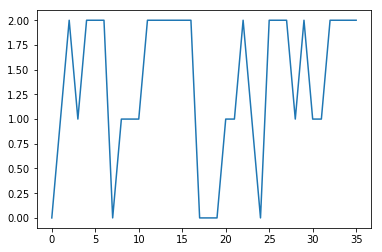

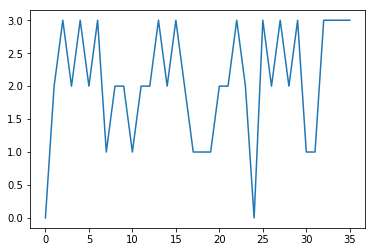

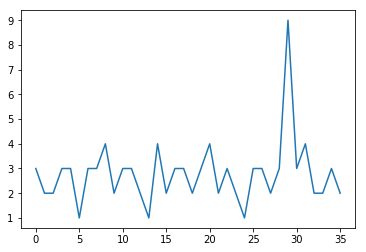

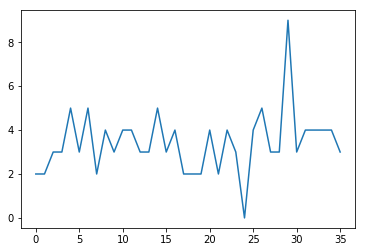

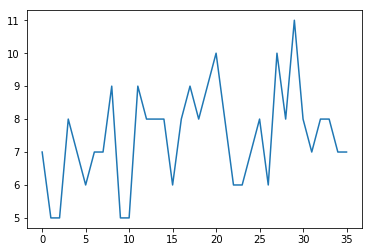

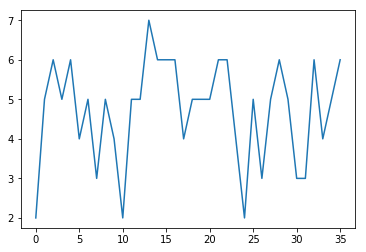

In [66]:
for cons in consensus:
    plt.figure()
    plt.plot([hm.generalised_hamming_distance(cons, segment) for segment in segments])

Open problems: how do I find the value of k? Charting the residual entropy or the res. entropy/k didn't help. Also looking at the consensus distance from the DNA segments as k varies, doesn't give a clear cut clue of the max value for k that should be assumed.